Cell 1 — Install & Imports

In [1]:
!pip install --upgrade ml_dtypes


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

print("✅ Runtime Reset Successful")
print("TensorFlow Version:", tf.__version__)
print("NumPy Version:", np.__version__)
print("Pandas Version:", pd.__version__)


✅ Runtime Reset Successful
TensorFlow Version: 2.19.0
NumPy Version: 2.0.2
Pandas Version: 2.2.2


Cell 2 — Load & quick inspect

In [3]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

print("✅ Libraries Imported Successfully")


✅ Libraries Imported Successfully


In [4]:
df = pd.read_csv("brisbane_water_quality.csv")

# Convert timestamp to datetime and sort
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df = df.sort_values('Timestamp')

# Select Dissolved Oxygen column
df = df[['Timestamp', 'Dissolved Oxygen']]
df = df.dropna()

print(df.head())
print("✅ Final Data Shape:", df.shape)


            Timestamp  Dissolved Oxygen
0 2023-08-04 23:00:00             7.472
2 2023-08-04 23:00:00             7.430
4 2023-08-04 23:00:00             7.429
5 2023-08-04 23:00:00             7.430
1 2023-08-04 23:30:00             7.455
✅ Final Data Shape: (26594, 2)


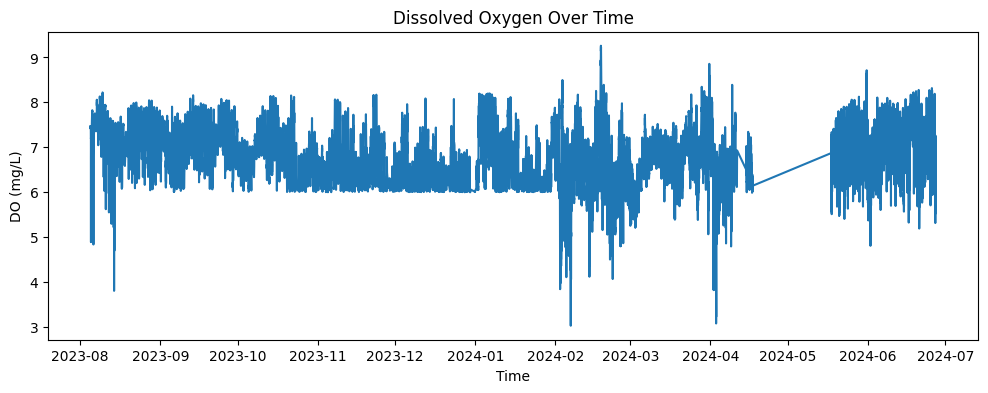

In [5]:
plt.figure(figsize=(12,4))
plt.plot(df['Timestamp'], df['Dissolved Oxygen'])
plt.title("Dissolved Oxygen Over Time")
plt.xlabel("Time")
plt.ylabel("DO (mg/L)")
plt.show()


In [6]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['Dissolved Oxygen']])


In [7]:
def create_sequences(data, timesteps=48):
    X, y = [], []
    for i in range(timesteps, len(data)):
        X.append(data[i-timesteps:i])
        y.append(data[i])
    return np.array(X), np.array(y)

timesteps = 48  # 24 hrs if data is 30 min interval

X, y = create_sequences(scaled_data, timesteps)
print("X Shape:", X.shape)
print("y Shape:", y.shape)


X Shape: (26546, 48, 1)
y Shape: (26546, 1)


In [8]:
split = int(0.8 * len(X))

X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print("Train:", X_train.shape, y_train.shape)
print("Test:", X_test.shape, y_test.shape)


Train: (21236, 48, 1) (21236, 1)
Test: (5310, 48, 1) (5310, 1)


In [9]:
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(timesteps, 1)),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 48, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 48, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,345 (114.63 KB)

 Trainable params: 29,345 (114.63 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)


Epoch 1/20
664/664 ━━━━━━━━━━━━━━━━━━━━ 40s 53ms/step - loss: 0.0134 - val_loss: 0.0028
Epoch 2/20
664/664 ━━━━━━━━━━━━━━━━━━━━ 28s 43ms/step - loss: 0.0039 - val_loss: 0.0025
Epoch 3/20
664/664 ━━━━━━━━━━━━━━━━━━━━ 28s 42ms/step - loss: 0.0028 - val_loss: 0.0018
Epoch 4/20
664/664 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - loss: 0.0020 - val_loss: 0.0017
Epoch 5/20
664/664 ━━━━━━━━━━━━━━━━━━━━ 27s 41ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 6/20
664/664 ━━━━━━━━━━━━━━━━━━━━ 27s 41ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 7/20
664/664 ━━━━━━━━━━━━━━━━━━━━ 41s 42ms/step - loss: 0.0011 - val_loss: 0.0015
Epoch 8/20
664/664 ━━━━━━━━━━━━━━━━━━━━ 41s 41ms/step - loss: 0.0011 - val_loss: 0.0015
Epoch 9/20
664/664 ━━━━━━━━━━━━━━━━━━━━ 41s 42ms/step - loss: 0.0010 - val_loss: 0.0016
Epoch 10/20
664/664 ━━━━━━━━━━━━━━━━━━━━ 27s 41ms/step - loss: 9.9993e-04 - val_loss: 0.0015
Epoch 11/20
664/664 ━━━━━━━━━━━━━━━━━━━━ 28s 42ms/step - loss: 9.3294e-04 - val_loss: 0.0015
Epoch 12/20
664/664 ━━

166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


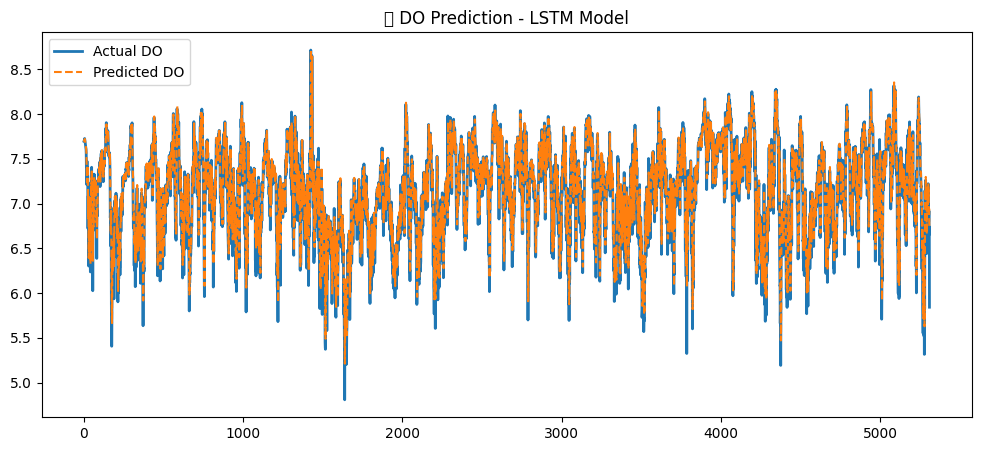

In [11]:
y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test)

plt.figure(figsize=(12,5))
plt.plot(y_test_inv, label="Actual DO", linewidth=2)
plt.plot(y_pred, label="Predicted DO", linestyle='dashed')
plt.legend()
plt.title("✅ DO Prediction - LSTM Model")
plt.show()


In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred))
mae = mean_absolute_error(y_test_inv, y_pred)
r2 = r2_score(y_test_inv, y_pred)

print(f"✅ Model Evaluation:")
print(f"RMSE: {rmse:.3f}")
print(f"MAE: {mae:.3f}")
print(f"R² Score: {r2:.3f}")


✅ Model Evaluation:
RMSE: 0.241
MAE: 0.177
R² Score: 0.781
